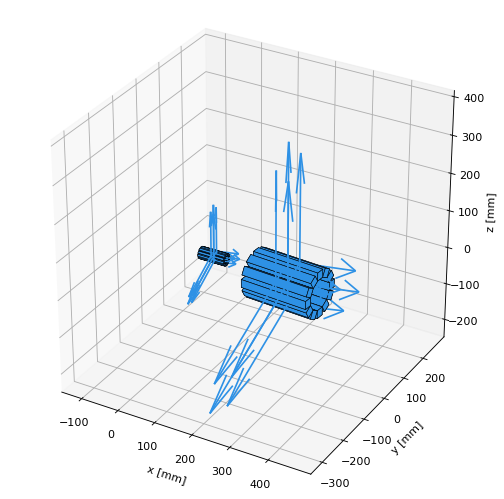

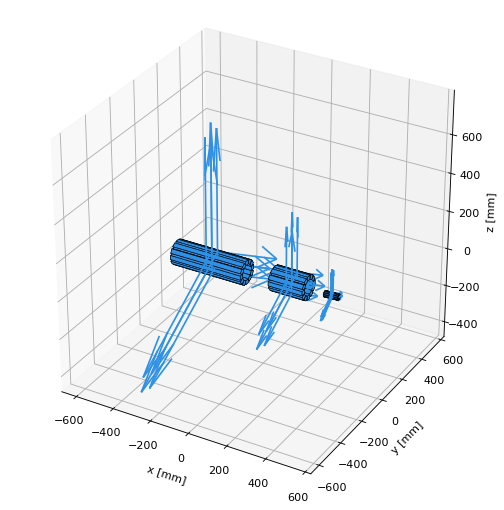

KeyboardInterrupt: 

In [46]:
import matplotlib.pyplot as plt
import numpy as np

from helper_tools import *

from storage_ring_modeler import StorageRingModel,make_optimal_solution_model
from phaseSpaceAnalyzer import SwarmSnapShot
from phaseSpaceAnalysis_Functions import make_phase_space_info,plot_ring_lattice_with_stops,emittance_from_particles,get_emittances
from math import sqrt
from particle_class import Swarm
m=7.0
model=make_optimal_solution_model('2',use_bumper=False,include_mag_cross_talk=True)

def temperature(momenta):
    sigma=np.std(momenta)
    return (sigma/91)**2 * m

In [ ]:

def thermal_swarm(num_particles,temp_swarm,r_max):
    sigma=91*sqrt(temp_swarm/m)
    momentums=np.random.normal(loc=(-model.lattice_ring.speed_nominal,0.0,0.0),scale=sigma,size=(num_particles,3))
    positions=[]
    while len(positions)<num_particles:
        y,z=r_max*2*(np.random.random(2)-.5)
        if sqrt(y**2+z**2)<r_max:
            positions.append([-1e-10,y,z])
    swarm_initial=Swarm()
    for P,Q in zip(momentums,positions):
        swarm_initial.add_new_particle(np.array(Q),np.array(P))
    return swarm_initial

In [42]:
from phaseSpaceAnalysis_Functions import transfer_particles_to_new_swarm
%matplotlib inline
T_max_sim=30.0
x0=1e-6
num_particles=500
temperature_swarm=.005
r_max=.5e-3
swarm_initial=thermal_swarm(num_particles,temperature_swarm,r_max)

x_max=T_max_sim*model.lattice_ring.speed_nominal
x_stops=np.arange(x0,x_max,model.lattice_ring.total_length)
phase_space_info=[[] for _ in x_stops]
work_size=30
swarm_traced=None
while len(swarm_initial)>0:
    print(len(swarm_initial))
    swarm_to_trace=transfer_particles_to_new_swarm(swarm_initial,work_size)
    swarm_traced=model.swarm_tracer_ring.trace_swarm_through_lattice(swarm_to_trace,5e-6,T_max_sim,parallel=True,steps_per_logging=4 ,use_fast_mode=False)
    for info,x_snap in zip(phase_space_info,x_stops):
        snap=SwarmSnapShot(swarm_traced,x_snap)
        info.extend(snap.particles)

300
270
240
210
180
150
120
90
60
30


In [43]:
T_min_analysis=T_max_sim*.9
x_min = min([particle.qo[0] for particle in phase_space_info[-1] if particle.T > T_min_analysis])
def is_valid(particle):
    return (particle.T>T_min_analysis and particle.qo[0]<x_min)
len([particle for particle in phase_space_info[0] if is_valid(particle)])
x_min

5573.612902632545

In [44]:
def get_valid_coords(idx):
    y= np.array([part.qo[1] for part in phase_space_info[idx] if is_valid(part)])
    z= np.array([part.qo[2] for part in phase_space_info[idx] if is_valid(part)])
    py=np.array([part.po[1] for part in phase_space_info[idx] if is_valid(part)])
    pz=np.array([part.po[2] for part in phase_space_info[idx] if is_valid(part)])
    return y,z,py,pz
temperatures=[]
for index,_ in enumerate(phase_space_info):
    _,_,py,pz=get_valid_coords(index)
    if len(py)!=0:
        temperatures.append([temperature(py),temperature(pz)])
temperatures=np.array(temperatures)

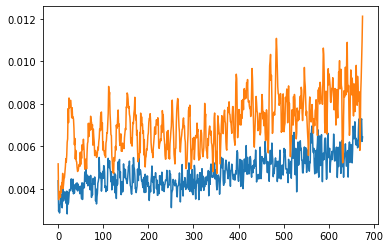

In [45]:
plt.plot(temperatures[:,0])
plt.plot(temperatures[:,1])
plt.show()

0.00458470545157878 0.004640831646213366


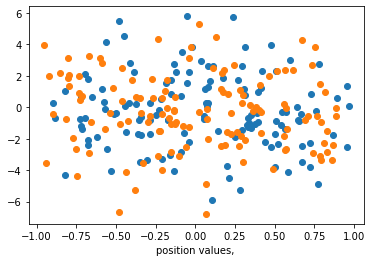

0.0048319034895266035 0.007554211994404819


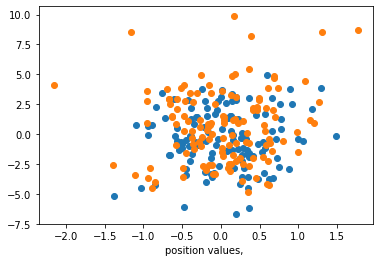

In [41]:
def plot_phase_space_valid(idx):
    y,z,py,pz=get_valid_coords(idx)
    y/=1e-3
    z/=1e-3
    print(temperature(py),temperature(pz))
    plt.scatter(y,py)
    plt.scatter(z,pz)
    plt.xlabel("position values, ")
    plt.show()
plot_phase_space_valid(0)
plot_phase_space_valid(10)

array([ 8.24727360e+00,  9.47629178e-04, -1.62824555e-04])